#### representation visualization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Layer
from tensorflow.keras.layers import Reshape, Concatenate

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.attention_weights = None  # Save attention weights here

    def call(self, inputs, training, return_attention=False):
        attn_output, attn_weights = self.att(inputs, inputs, return_attention_scores=True)
        self.attention_weights = attn_weights  # Save attention weights
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        if return_attention:
            return self.layernorm2(out1 + ffn_output), attn_weights
        return self.layernorm2(out1 + ffn_output)
        
def build_cascade_transformer_model_with_fingerprint(input_shape, fingerprint_shape, num_heads=4, ff_dim=128, task1_classes=2, task2_classes=2):
    # Primary input for sequence data
    sequence_input = Input(shape=input_shape, name="sequence_input")  # Shape: (sequence_length, feature_dim)

    # Fingerprint input
    fingerprint_input = Input(shape=(fingerprint_shape,), name="fingerprint_input")  # Shape: (fingerprint_dim,)
    fingerprint_dense = Dense(input_shape[1], activation="relu", name="fingerprint_dense")(fingerprint_input)  # Match feature_dim
    fingerprint_expanded = Reshape((1, input_shape[1]), name="fingerprint_expanded")(fingerprint_dense)  # Shape: (1, feature_dim)

    # Combine sequence input and fingerprint input along the sequence dimension
    combined_input = Concatenate(axis=1, name="combined_input")([sequence_input, fingerprint_expanded])  # Shape: (sequence_length + 1, feature_dim)

    # First Transformer Block
    x = TransformerBlock(embed_dim=input_shape[1], num_heads=num_heads, ff_dim=ff_dim)(combined_input)
    x = TransformerBlock(embed_dim=input_shape[1], num_heads=num_heads, ff_dim=ff_dim)(x)
    x = Flatten()(x)
    shared_dense = Dense(input_shape[1], activation='relu', name="shared_dense_1")(x)
    shared_dense_task1 = Dense(128, activation='relu', name="shared_dense_2")(shared_dense)
    shared_dense_task1 = Dense(32, activation='relu', name="shared_dense_3")(shared_dense_task1)
    shared_dropout = Dropout(0.3, name="shared_dropout_1")(shared_dense_task1)

    # Task 1 Output
    task1_output = Dense(task1_classes, activation='softmax', name="task1_output")(shared_dropout)

    # Cascade Task 1 Output to Task 2 Input
    task1_features = Dense(input_shape[1], activation='relu', name="task1_features")(task1_output)
    task1_features_expanded = tf.expand_dims(task1_features, axis=1)

    # Expand shared_dense and concatenate with task1_features
    shared_dense_expanded = tf.expand_dims(shared_dense, axis=1)
    cascade_input = tf.concat([shared_dense_expanded, task1_features_expanded], axis=1)  # Shape: (batch_size, 2, input_shape[1])

    # Task 2 Transformer Block
    task2_x = TransformerBlock(embed_dim=input_shape[1], num_heads=num_heads, ff_dim=ff_dim)(cascade_input)
    task2_x = Flatten()(task2_x)
    task2_x = Dense(128, activation='relu', name="task2_dense_1")(task2_x)
    task2_x = Dense(32, activation='relu', name="task2_dense_2")(task2_x)

    # Task 2 Output
    task2_output = Dense(task2_classes, activation='softmax', name="task2_output")(task2_x)

    # Build Model
    model = Model(inputs=[sequence_input, fingerprint_input], outputs=[task1_output, task2_output], name="cascade_transformer_with_fingerprint")
    return model

In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load the trained model
model = build_cascade_transformer_model_with_fingerprint(
    input_shape=(1024, 80),
    fingerprint_shape=881
)
model.load_weights('../model/cascade_transformer_model_weights.h5')

# Define input data
train_inputs = np.load('../datasets/train_data/train_inputs.npy').astype('float32')
train_fingerprints = np.load('../datasets/train_data/train_fingerprints.npy').astype('float32')

# Extract embeddings for Task 1 (from the layer before task1_output)
embedding_task1_model = Model(inputs=model.input, outputs=model.get_layer("shared_dense_3").output)
embedding_task1 = embedding_task1_model.predict([train_inputs, train_fingerprints])

# Extract embeddings for Task 2 (from the layer before task2_output)
embedding_task2_model = Model(inputs=model.input, outputs=model.get_layer("task2_dense_2").output)
embedding_task2 = embedding_task2_model.predict([train_inputs, train_fingerprints])

train_labels_patho = np.load('../datasets/train_data/train_labels_patho.npy')
train_labels_label = np.load('../datasets/train_data/train_labels_label.npy')

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


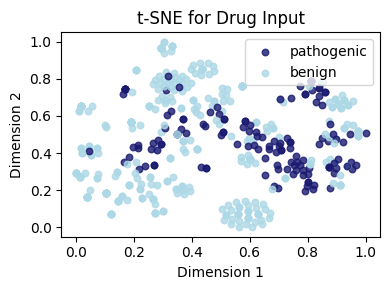

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


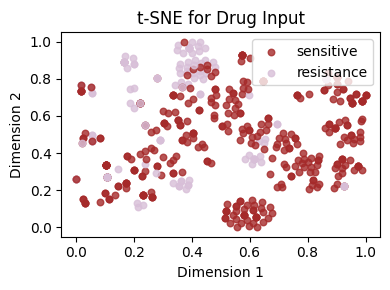

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


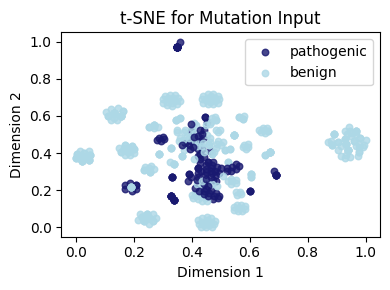

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


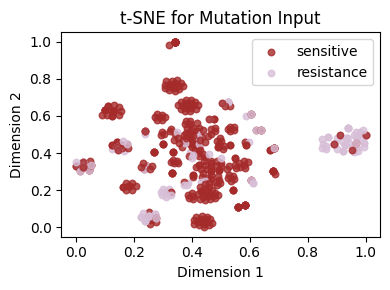

In [3]:
def plot_tsne(input_data, labels, title, colors,path,annos):

    pca = PCA(n_components=32)
    pca_result = pca.fit_transform(input_data)

    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30, learning_rate=200)
    tsne_result = tsne.fit_transform(pca_result)
    
    # Normalize the t-SNE results to [0, 1]
    x_min, x_max = np.min(tsne_result, 0), np.max(tsne_result, 0)
    tsne_result = (tsne_result - x_min) / (x_max - x_min)
    
    plt.figure(figsize=(4, 3))
    annos1,annos2=0,0
    for i in range(tsne_result.shape[0]):
        if(labels[i] == 0):
            if(annos1 == 0):
                plt.scatter(tsne_result[i, 0], tsne_result[i, 1], s=22, color=colors[labels[i]], alpha=0.8, label=annos[labels[i]])
                annos1 = 1
            else:
                plt.scatter(tsne_result[i, 0], tsne_result[i, 1], s=22, color=colors[labels[i]], alpha=0.8)
        if(labels[i] == 1):
            if(annos2 == 0):
                plt.scatter(tsne_result[i, 0], tsne_result[i, 1], s=22, color=colors[labels[i]], alpha=0.8, label=annos[labels[i]])
                annos2 = 1
            else:
                plt.scatter(tsne_result[i, 0], tsne_result[i, 1], s=22, color=colors[labels[i]], alpha=0.8)
    
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.savefig(path,dpi=300)
    plt.show()

# Assuming task1_labels and task2_labels are the true labels for Task 1 and Task 2

task1_labels = np.argmax(train_labels_patho, axis=1)
task2_labels = np.argmax(train_labels_label, axis=1)
colors_task1 = ['#191970', '#ADD8E6']  # Dark gray-blue and light gray-blue for Task 1
colors_task2 = ['#A52A2A', '#D8BFD8']  # Dark gray-pink and light gray-pink for Task 2
plot_tsne(train_fingerprints, task1_labels, "t-SNE for Drug Input", colors_task1, 'images/representation/input_drug_task1.png',['pathogenic','benign'])
plot_tsne(train_fingerprints, task2_labels, "t-SNE for Drug Input", colors_task2, 'images/representation/input_drug_task2.png',['sensitive','resistance'])

train_inputs_flattened = train_inputs.reshape(train_inputs.shape[0], -1)
plot_tsne(train_inputs_flattened, task1_labels, "t-SNE for Mutation Input", colors_task1, 'images/representation/input_mutation_task1.png',['pathogenic','benign'])
plot_tsne(train_inputs_flattened, task2_labels, "t-SNE for Mutation Input", colors_task2, 'images/representation/input_mutation_task2.png',['sensitive','resistance'])

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


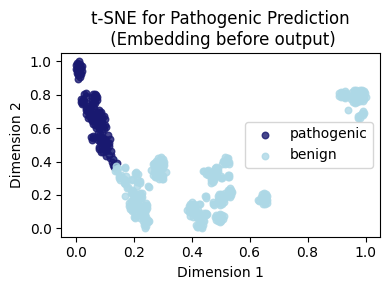

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


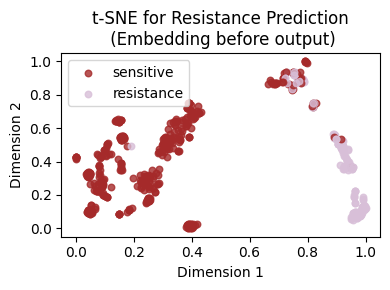

In [4]:
# For Task 1
plot_tsne(embedding_task1, task1_labels, "t-SNE for Pathogenic Prediction\n (Embedding before output)", colors_task1, 'images/representation/output_task1.png',['pathogenic','benign'])

# For Task 2
plot_tsne(embedding_task2, task2_labels, "t-SNE for Resistance Prediction\n (Embedding before output)", colors_task2, 'images/representation/ouput_task2.png',['sensitive','resistance'])